In [5]:
from PIL import Image
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import glacierml as gl
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans
import seaborn as sns
pd.set_option('display.max_columns', None)


        
# RGI.to_csv('Farinotti_mean_thickness_RGI_ID.csv')


In [11]:
df1= pd.read_csv('reference_thicknesses/Farinotti_vol.csv')
df1 = df1.drop('Unnamed: 0', axis = 1)
df1 = df1.dropna()

RGI = gl.RGI_loader(
    pth = '/home/simonhans/data/prethicktor/RGI/rgi60-attribs/'
)
RGI = RGI.sort_values('RGIId')

RGIf = pd.merge(RGI, df1, on = 'RGIId')
RGIf = RGIf.dropna()

df = RGIf
df = df.dropna()
df['region'] = df['RGIId'].str[6:8]
df = df.rename(columns = {'Area_x':'Area'})
kmeans = KMeans(n_clusters = 10, random_state = 0)
dft = df[[
    'CenLat',
    'CenLon',
    'Area',
    'Aspect',
    'Lmax',
    'Slope',
    'Zmin',
    'Zmax'
]]
df['cluster'] = kmeans.fit_predict(dft)
df['region'] = df['RGIId'].str[6:8]
df



RGIId   CenLat    CenLon  Slope  Zmin  Zmed  Zmax   Area  \
0       RGI60-01.00001  63.6890 -146.8230   42.0  1936  2385  2725  0.360   
1       RGI60-01.00002  63.4040 -146.6680   16.0  1713  2005  2144  0.558   
2       RGI60-01.00003  63.3760 -146.0800   18.0  1609  1868  2182  1.685   
3       RGI60-01.00004  63.3810 -146.1200   19.0  1273  1944  2317  3.681   
4       RGI60-01.00005  63.5510 -147.0570   16.0  1494  1914  2317  2.573   
...                ...      ...       ...    ...   ...   ...   ...    ...   
215523  RGI60-19.02748 -53.9860  -37.7325   29.9   310  -999   510  0.042   
215524  RGI60-19.02749 -54.8310  -36.1361   23.6   330  -999   830  0.567   
215525  RGI60-19.02750 -54.1884  -37.3018   16.8    10  -999  1110  4.118   
215526  RGI60-19.02751 -68.8656  -90.4266    0.4   170  -999   270  0.011   
215527  RGI60-19.02752 -46.8972   37.7140    9.6   970  -999  1170  0.528   

        Aspect  Lmax             0    Area_y region  cluster  
0          346   839  7.638771e+06  0.360625     01        9  
1          162  1197  1.697646e+07  0.556250     01        9  
2          175  2106  5.969346e+07  1.680625     01        9  
3          195  4175  1.952248e+08  3.678125     01        8  
4          181  2981  1.221541e+08  2.570625     01        8  
...        ...   ...           ...       ...    ...      ...  
215523     315   255  5.502906e+05  0.042500     19        0  
215524     200  1130  1.300672e+07  0.568125     19        0  
215525     308  4329  2.506893e+08  4.118125     19        8  
215526     122   106  1.068206e+05  0.010625     19        0  
215527      35    -9  1.489316e+07  0.526250     19        0  

[215528 rows x 14 columns]

In [15]:
df['Edasi Mean Thickness'] = np.nan
arch = '64-48'
top_learning_rate = 0.01
epochs = 100
dropout = 1

df7 = gl.data_loader(
root_dir = '/home/simonhans/data/prethicktor/'
)
module = 'sm7'
res = 'sr7'
dataset = df7 
dataset.name = 'df7'
rootdir = 'saved_models/' + module + '/sm_' + str(arch) + '/'

RGI_for_predictions = df[[
    'CenLon',
    'CenLat',
    'Area',
    'Aspect',
    'Lmax',
    'Slope',
    'Zmax',
    'Zmed',
    'Zmin'
]]

dnn_model = {}
RS = range(0,25,1)
for rs in tqdm((RS)):
    model_name = (
        str(arch) + 
        '_' + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )   

    model_path = (
        rootdir + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )

    dnn_model[model_name] = tf.keras.models.load_model(model_path)


    y = dnn_model[model_name].predict(RGI_for_predictions, verbose = 0)
    df = pd.concat([df, pd.Series(y.flatten(), name = rs)], axis = 1)




df_y = df[[
    0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
]]

df['Edasi Mean Thickness'] = df_y.mean(axis = 1)

#         df['Edasi Mean Thickness'] = df_y.mean(axis = 1)

df = df.drop([
    0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
], axis = 1)

100%|███████████████████████████████████████████| 25/25 [02:40<00:00,  6.42s/it]


In [26]:
# df[df['RGIId'].str.contains('RGI60-' + str('01'), na = False)]

df['Thickness'] = (df['0'] / 1e6)/ df['Area']
print(sum(df['0']) / 1e6 / sum(df['Area']))
df

224.14007138225386


RGIId   CenLat    CenLon  Slope  Zmin  Zmed  Zmax   Area  \
0       RGI60-01.00001  63.6890 -146.8230   42.0  1936  2385  2725  0.360   
1       RGI60-01.00002  63.4040 -146.6680   16.0  1713  2005  2144  0.558   
2       RGI60-01.00003  63.3760 -146.0800   18.0  1609  1868  2182  1.685   
3       RGI60-01.00004  63.3810 -146.1200   19.0  1273  1944  2317  3.681   
4       RGI60-01.00005  63.5510 -147.0570   16.0  1494  1914  2317  2.573   
...                ...      ...       ...    ...   ...   ...   ...    ...   
215523  RGI60-19.02748 -53.9860  -37.7325   29.9   310  -999   510  0.042   
215524  RGI60-19.02749 -54.8310  -36.1361   23.6   330  -999   830  0.567   
215525  RGI60-19.02750 -54.1884  -37.3018   16.8    10  -999  1110  4.118   
215526  RGI60-19.02751 -68.8656  -90.4266    0.4   170  -999   270  0.011   
215527  RGI60-19.02752 -46.8972   37.7140    9.6   970  -999  1170  0.528   

        Aspect  Lmax             0    Area_y region  cluster  \
0          346   839  7.638771e+06  0.360625     01        9   
1          162  1197  1.697646e+07  0.556250     01        9   
2          175  2106  5.969346e+07  1.680625     01        9   
3          195  4175  1.952248e+08  3.678125     01        8   
4          181  2981  1.221541e+08  2.570625     01        8   
...        ...   ...           ...       ...    ...      ...   
215523     315   255  5.502906e+05  0.042500     19        0   
215524     200  1130  1.300672e+07  0.568125     19        0   
215525     308  4329  2.506893e+08  4.118125     19        8   
215526     122   106  1.068206e+05  0.010625     19        0   
215527      35    -9  1.489316e+07  0.526250     19        0   

        Edasi Mean Thickness  Thickness  
0                1815.097778  21.218808  
1                1434.955444  30.423763  
2                1457.036621  35.426383  
3                1559.810791  53.035805  
4                1549.726074  47.475344  
...                      ...        ...  
215523            259.771942  13.102156  
215524            456.240662  22.939534  
215525            647.711975  60.876459  
215526            148.046478   9.710965  
215527            666.570496  28.206733  

[215528 rows x 16 columns]

 47%|████████████████████▊                       | 9/19 [02:01<02:15, 13.53s/it]


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

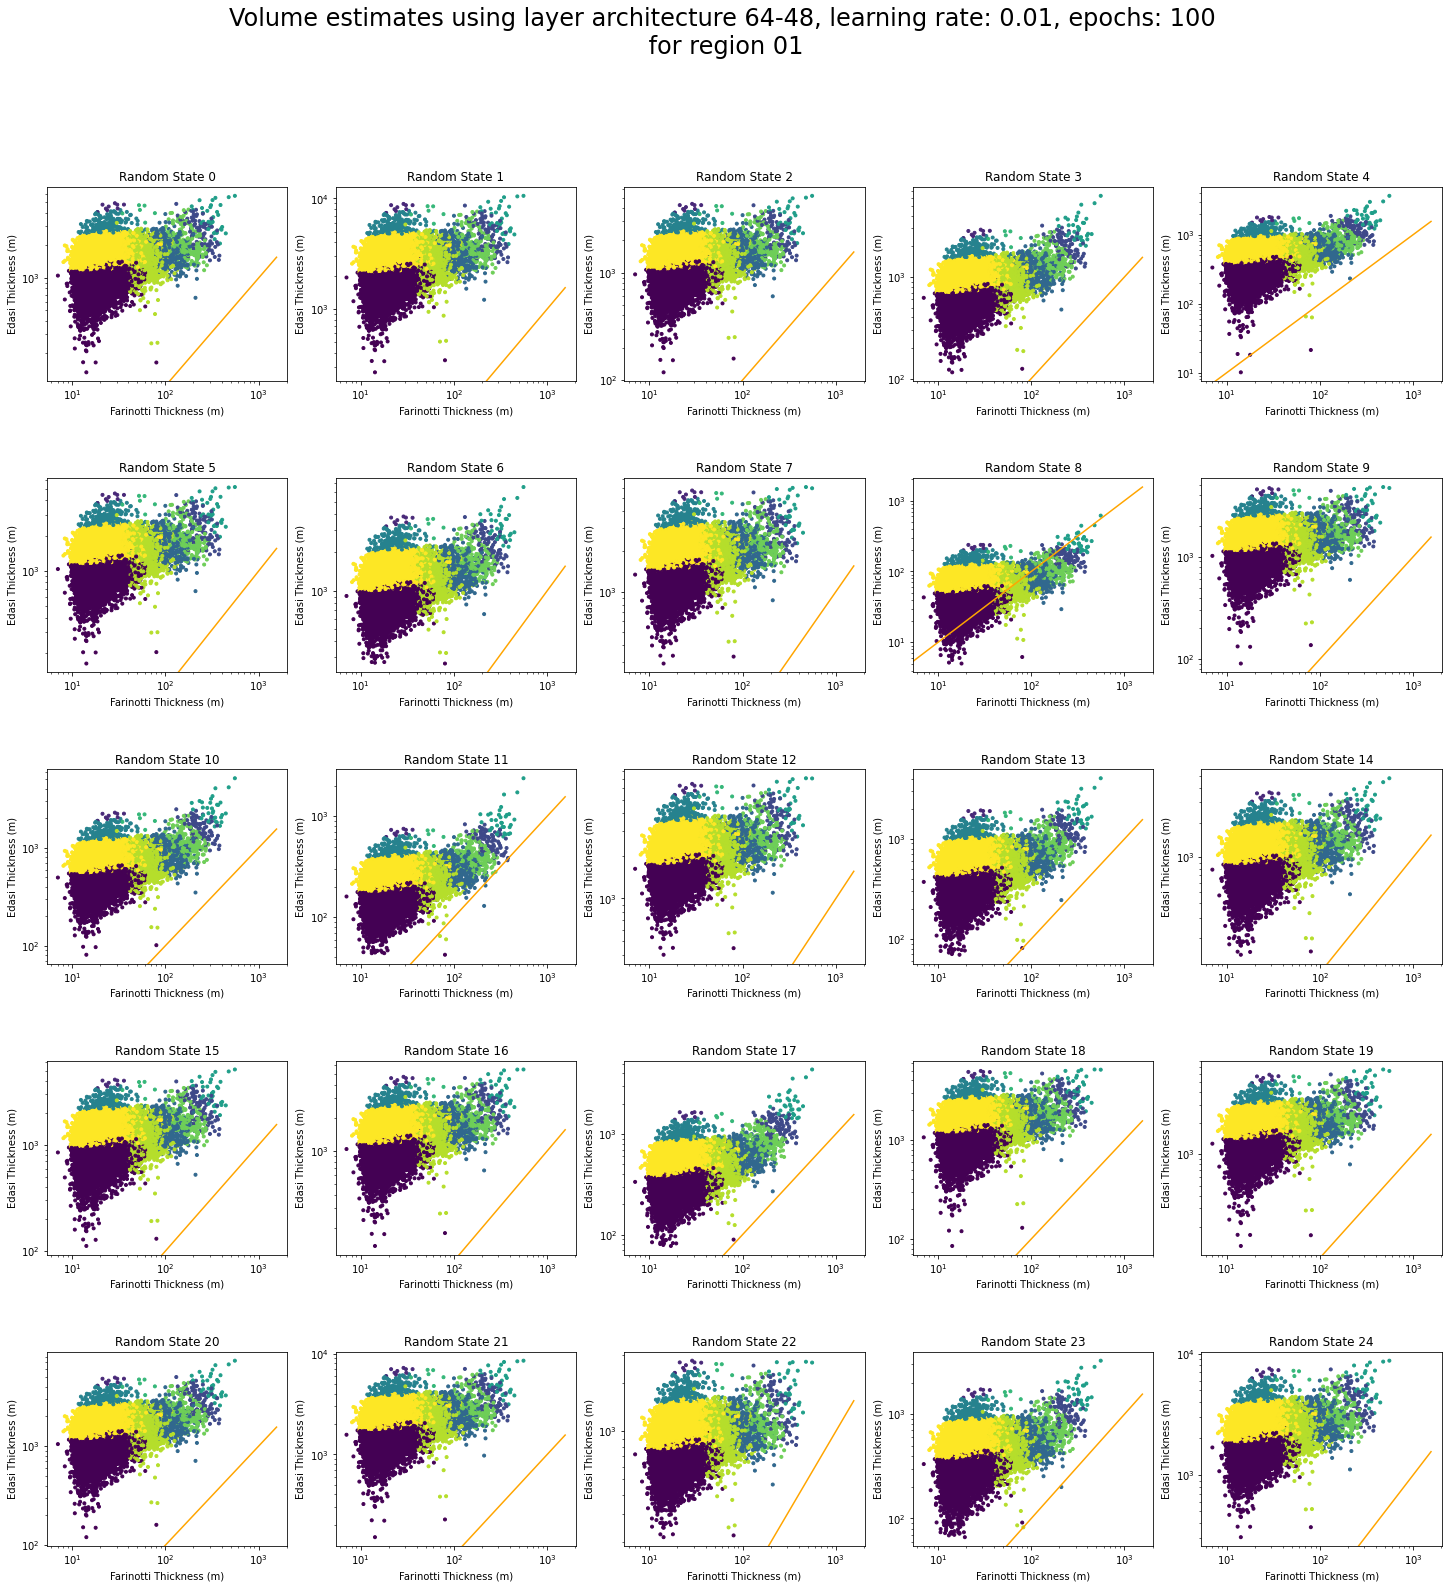

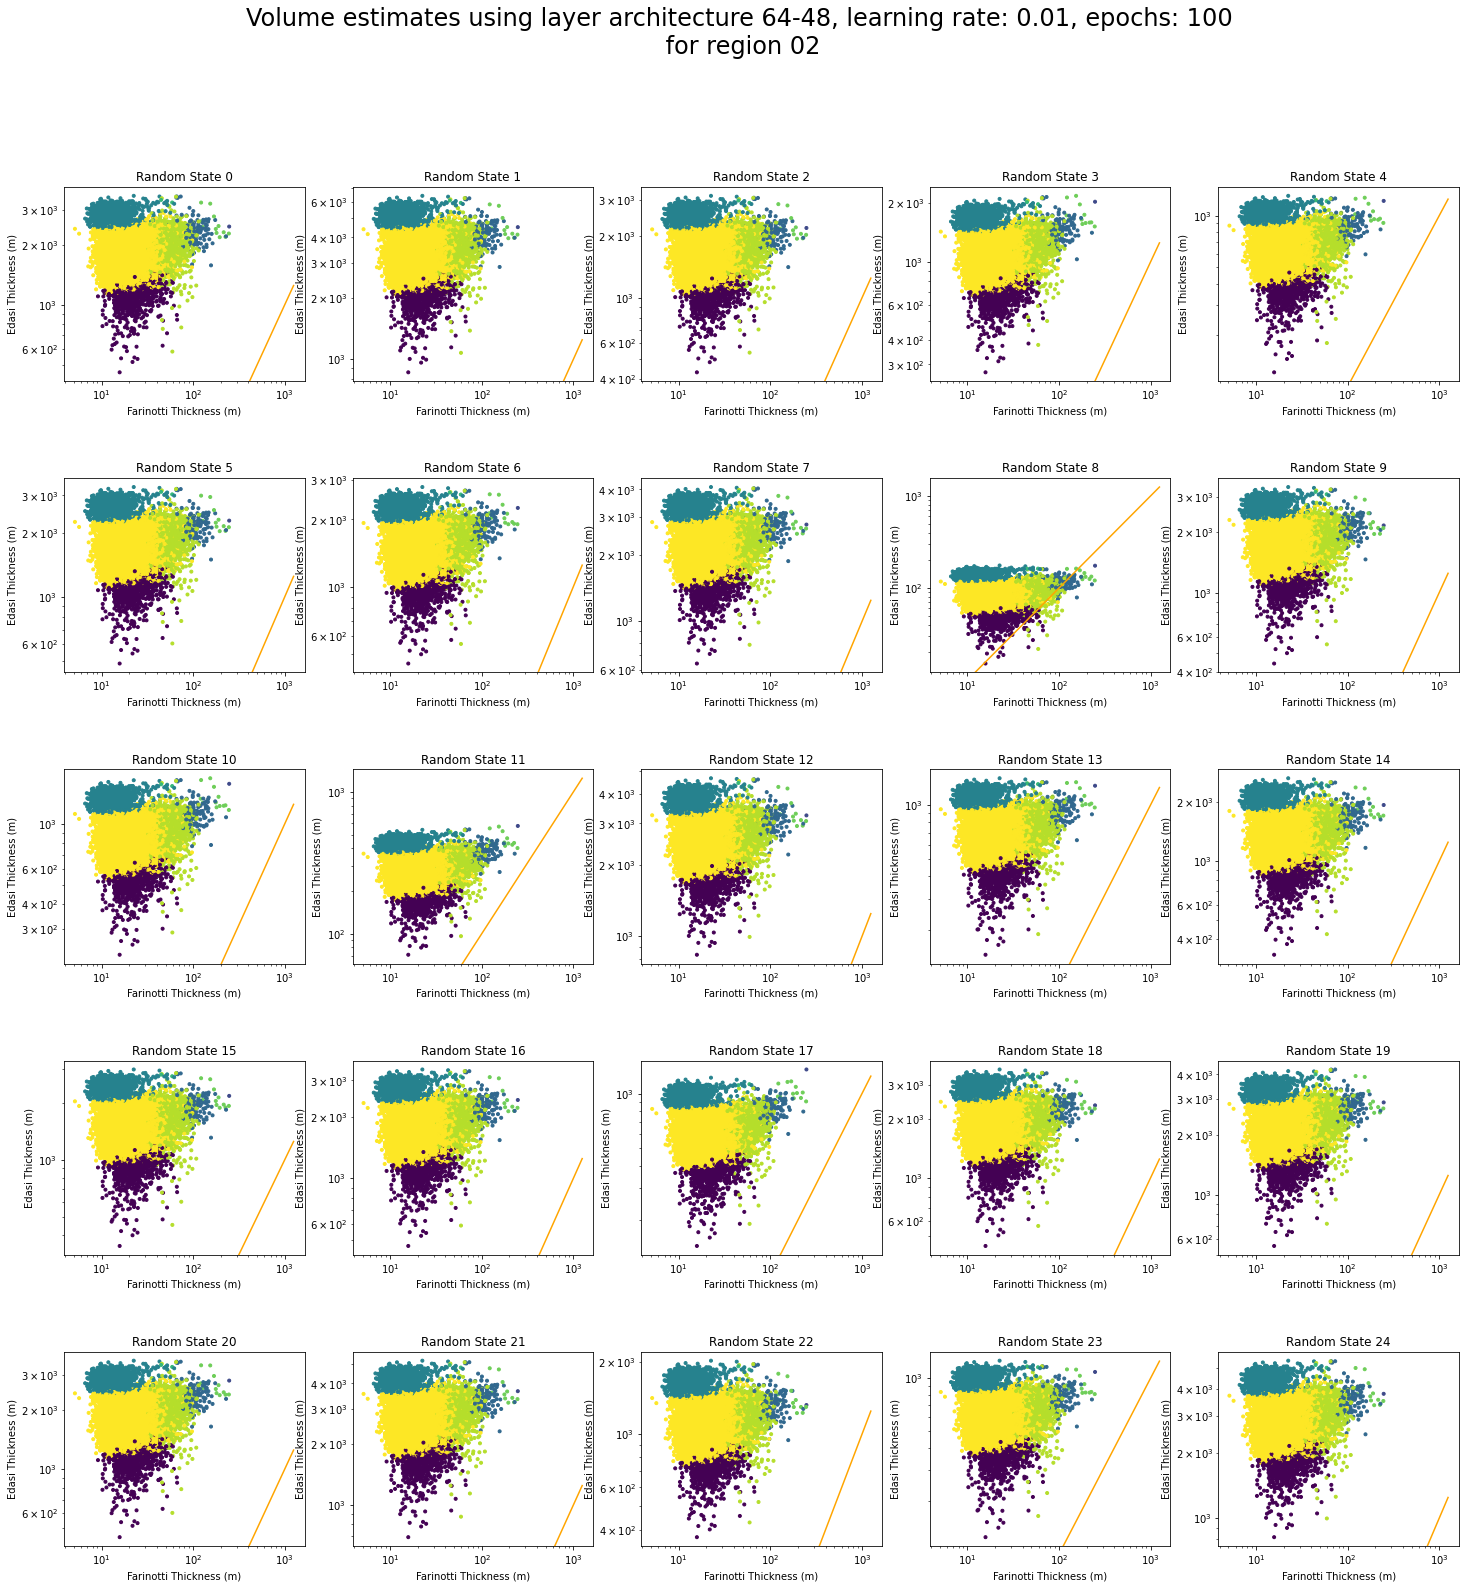

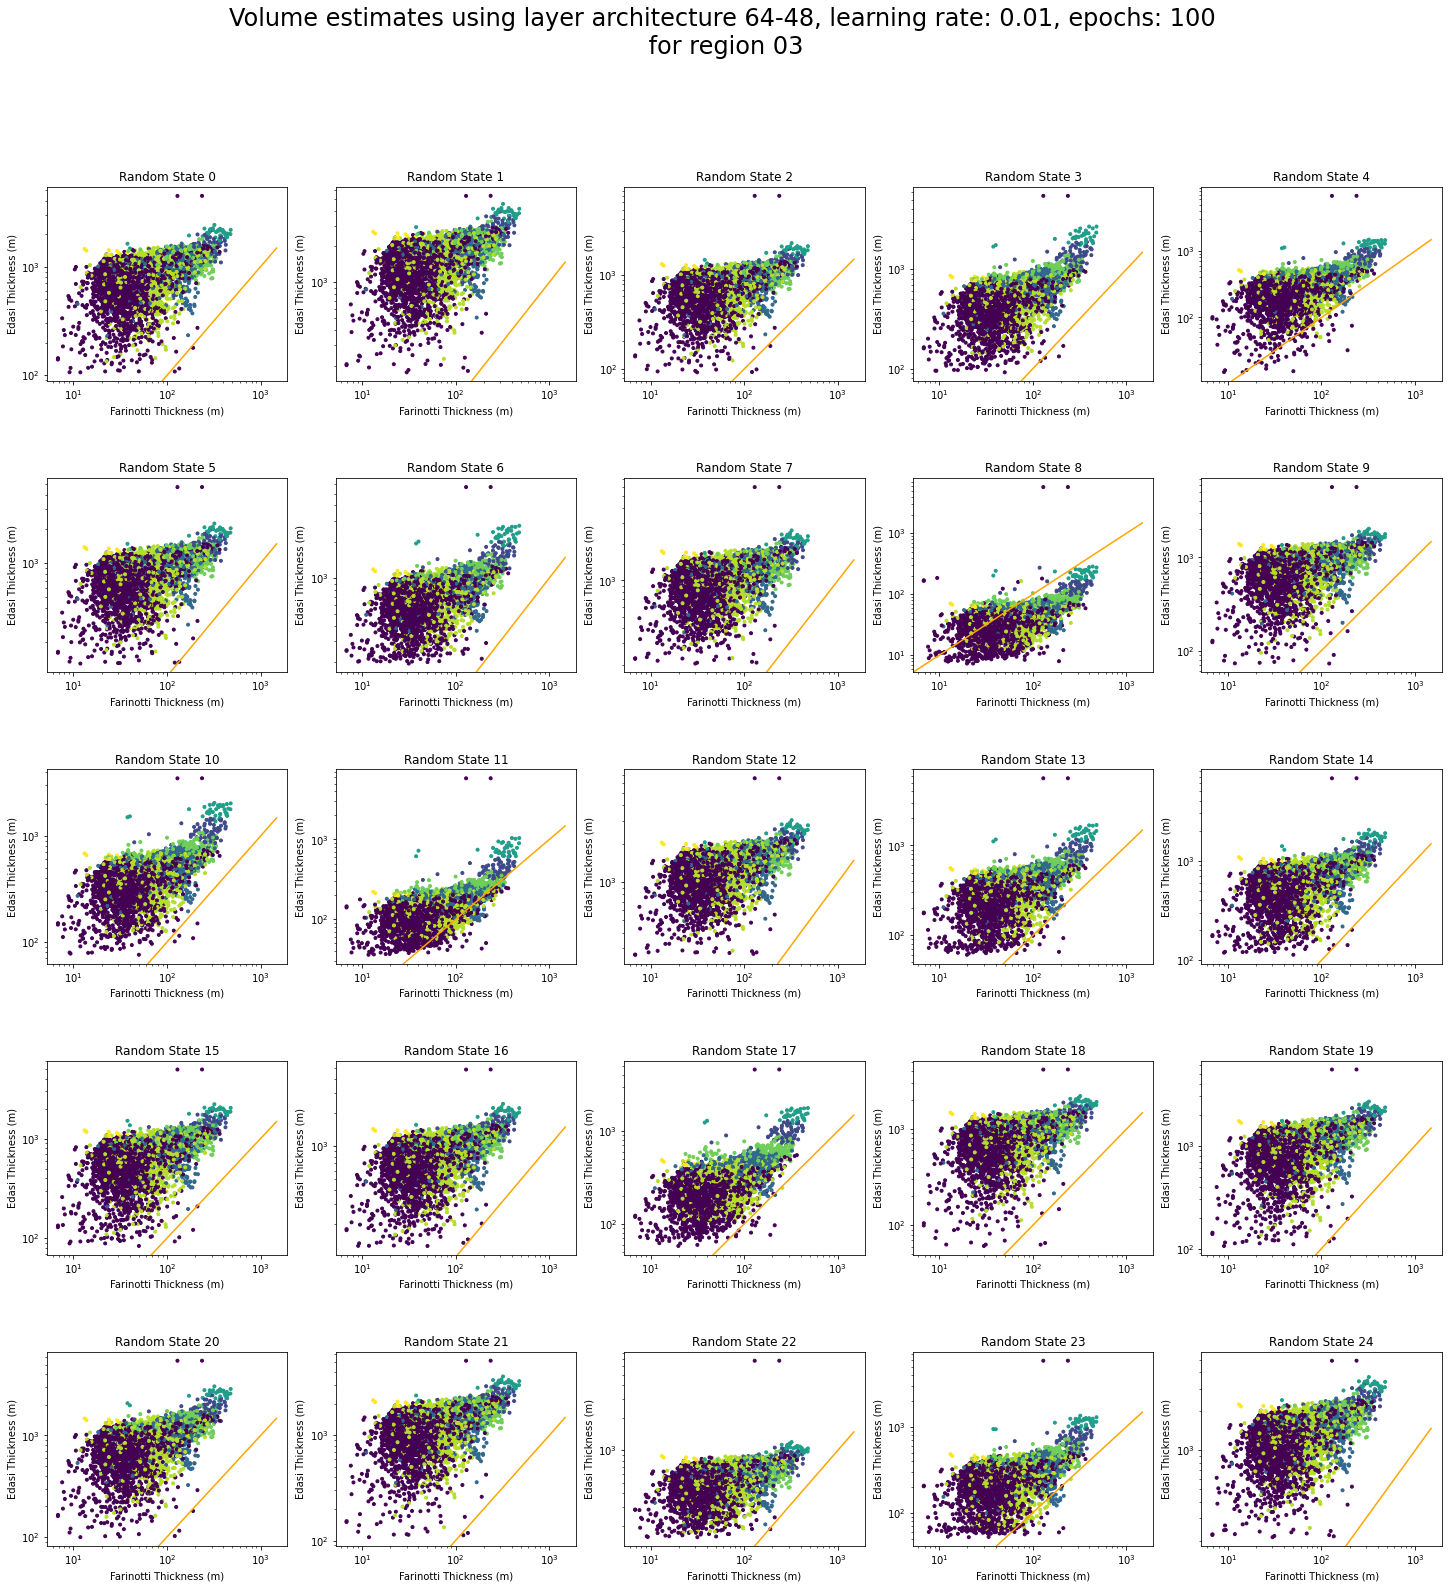

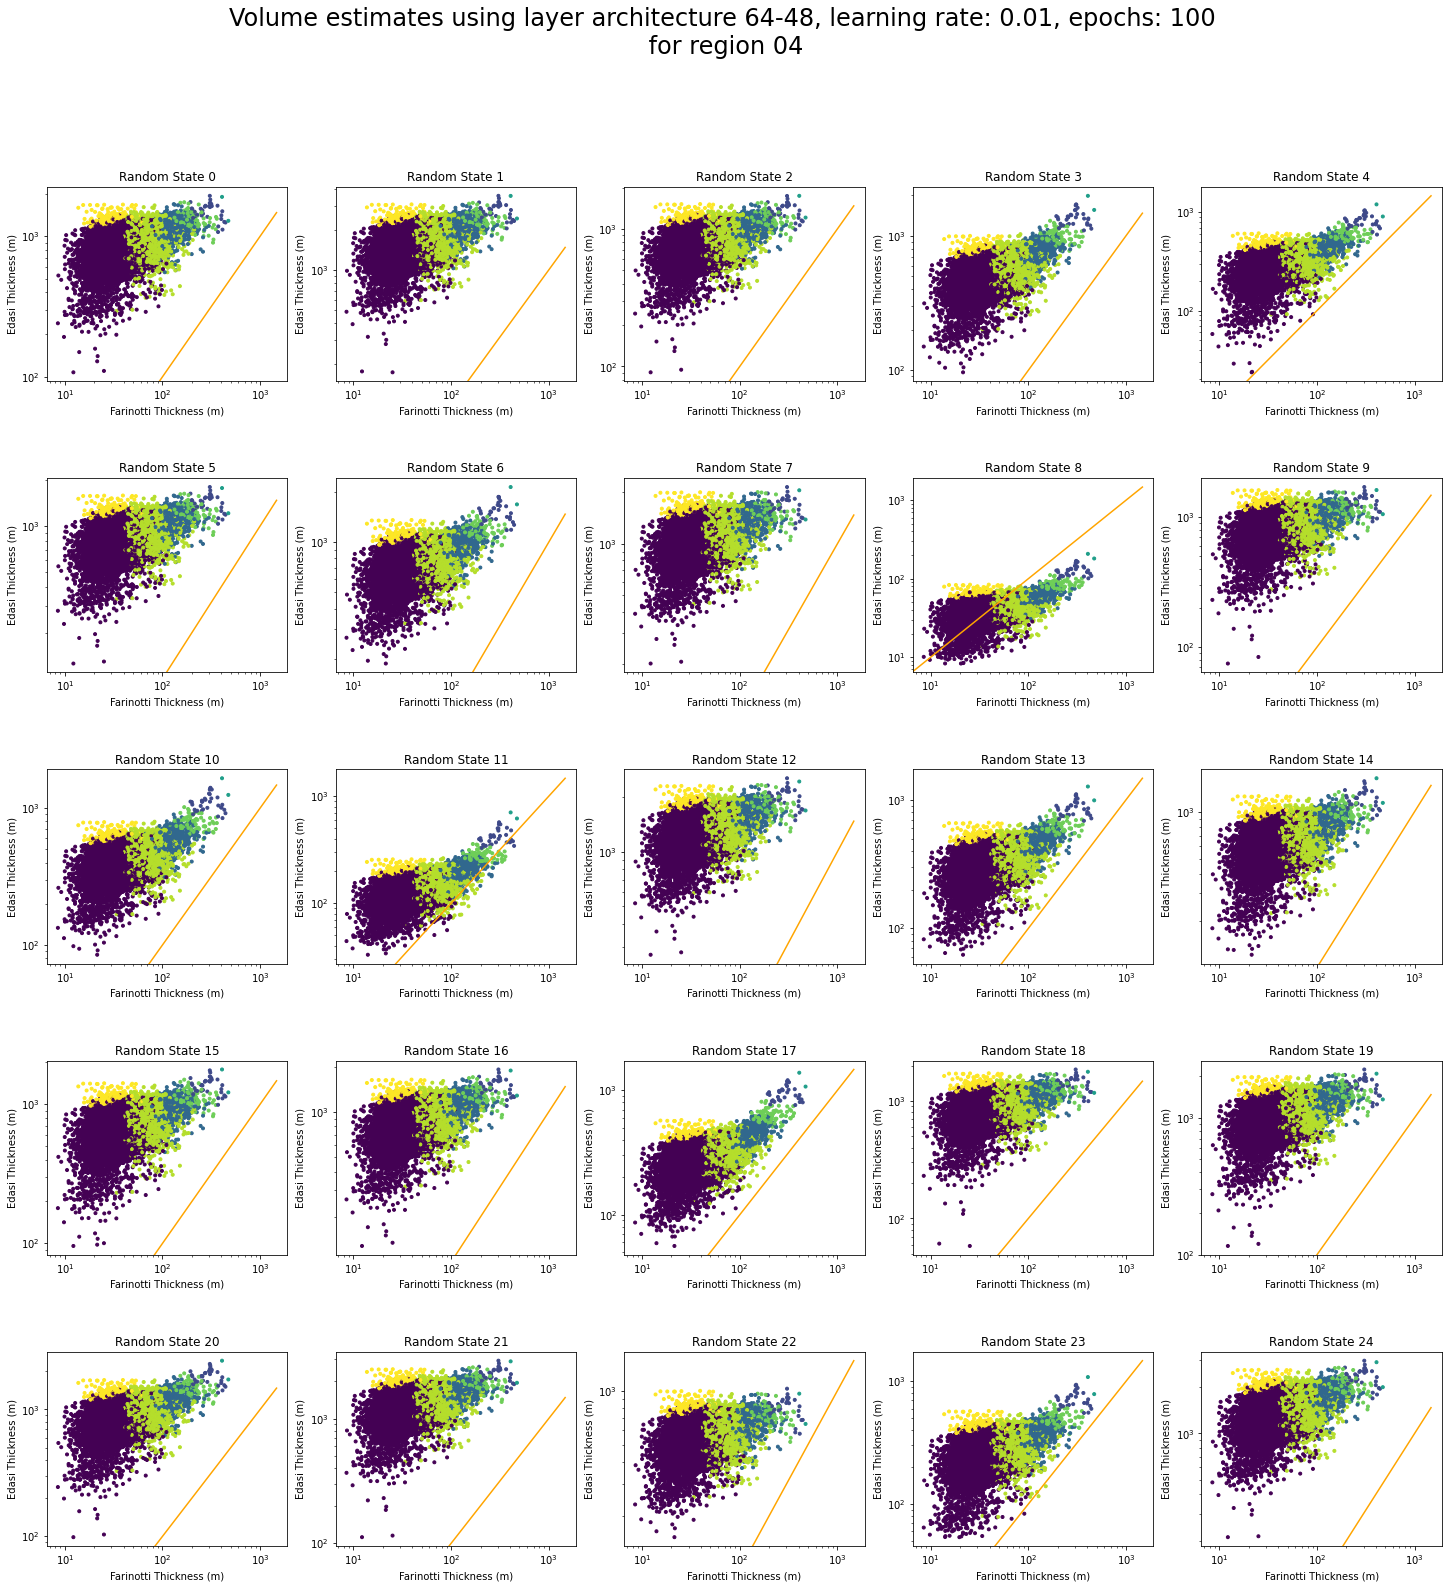

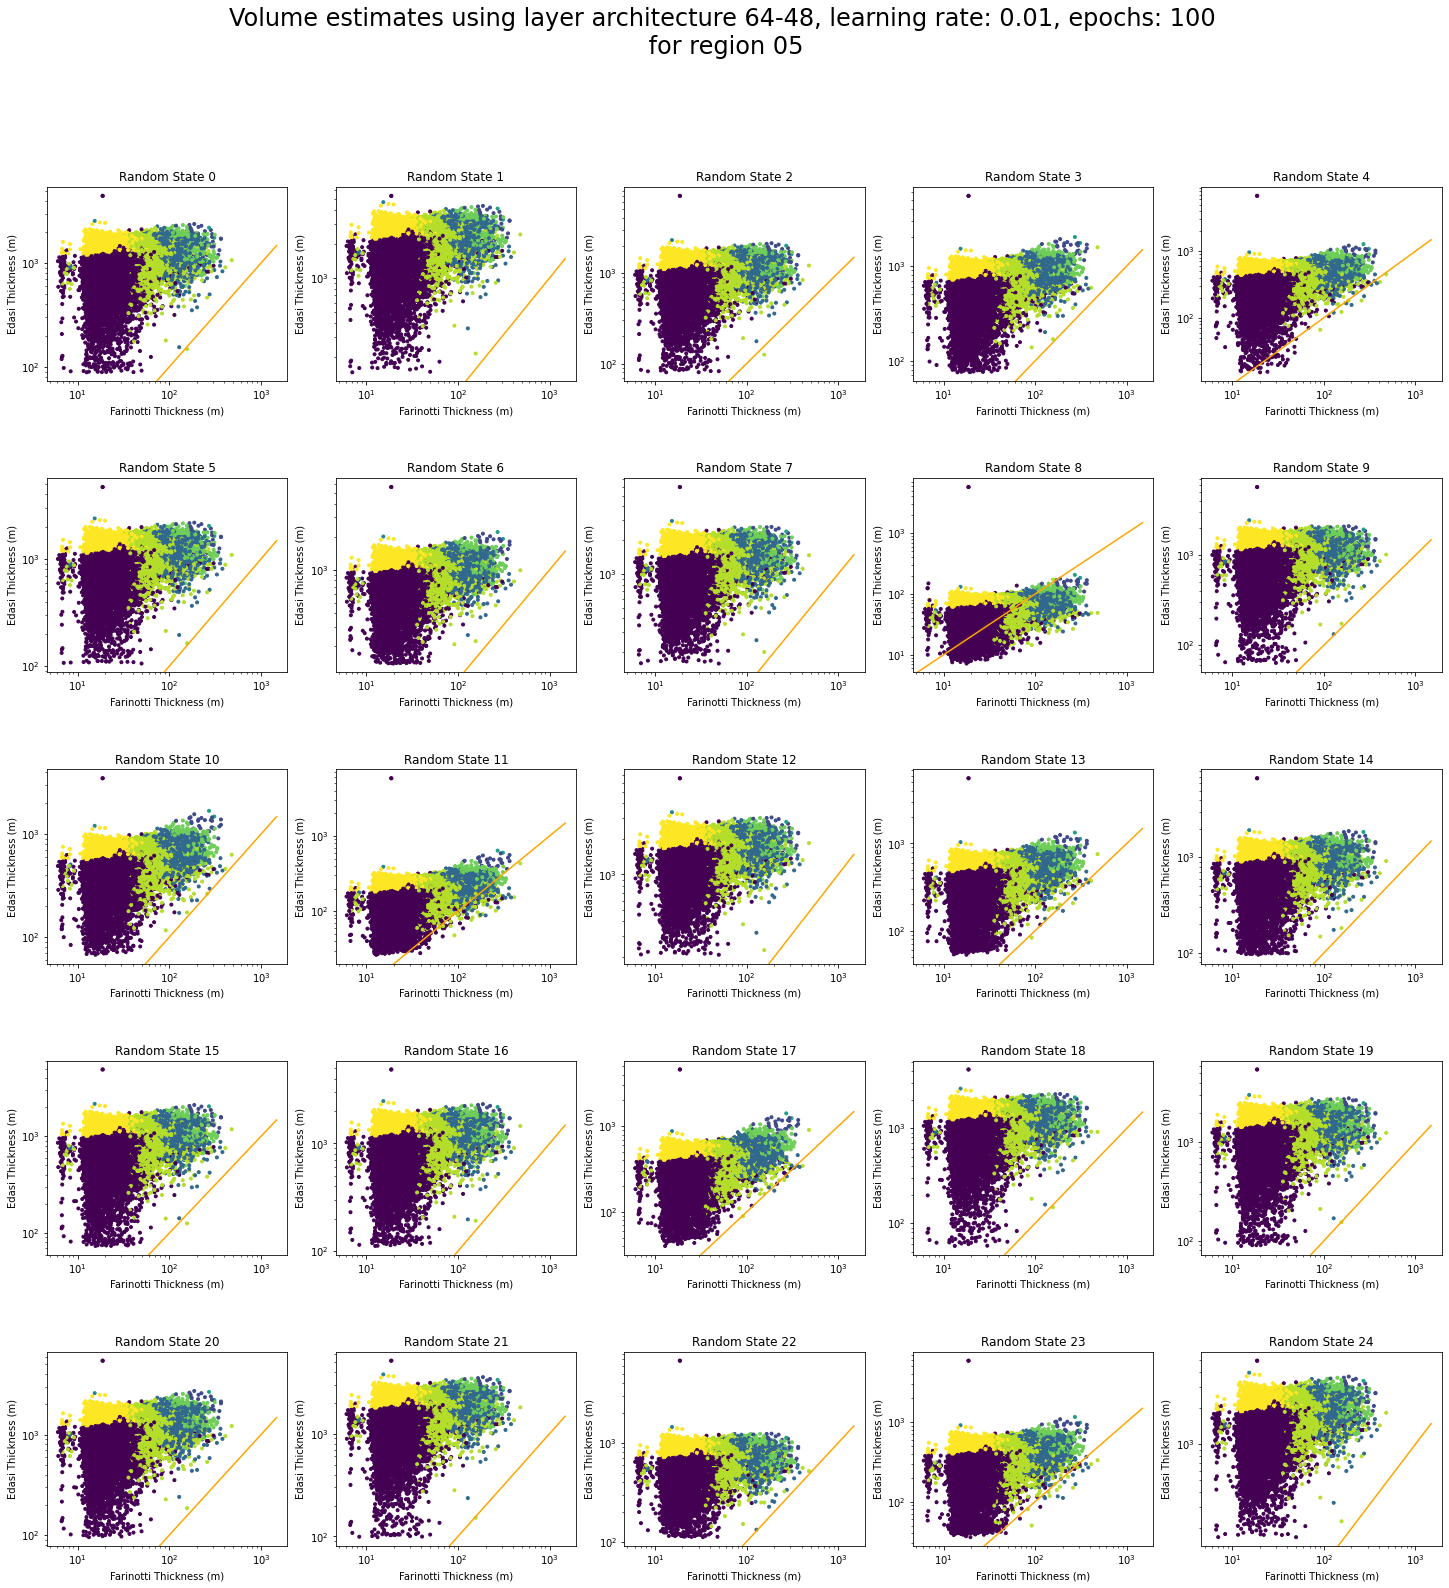

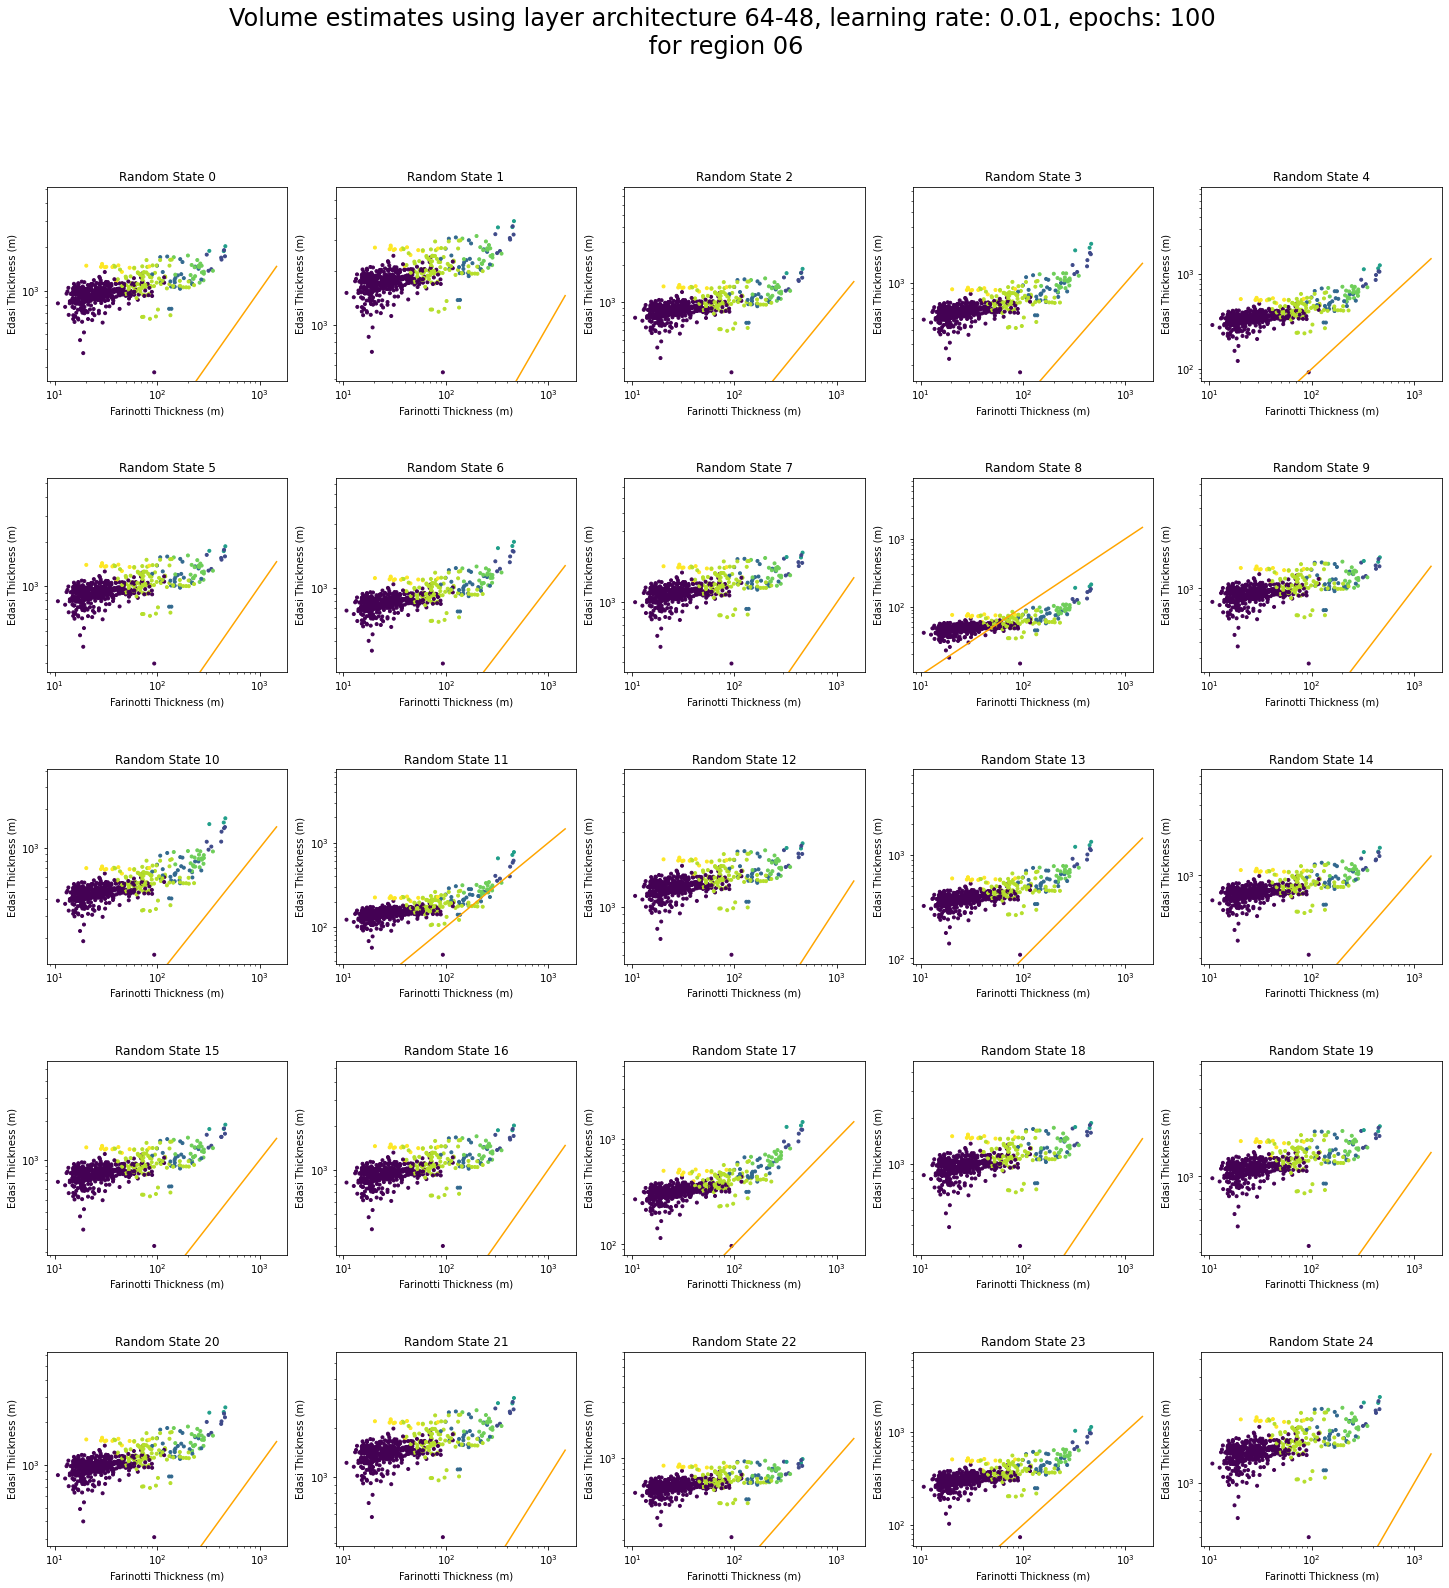

In [ ]:
arch = '64-48'
top_learning_rate = 0.01
epochs = 100
dropout = 1

df7 = gl.data_loader(
root_dir = '/home/simonhans/data/prethicktor/'
)
module = 'sm7'
res = 'sr7'
dataset = df7
dataset.name = 'df7'
rootdir = 'saved_models/' + module + '/sm_' + str(arch) + '/'

pth_2 = '/home/simonhans/data/prethicktor/RGI/rgi60-attribs/'
# pth_2 = '/data/fast1/glacierml/data/RGI/rgi60-attribs/'

for region_number in tqdm(range(1,20,1)):
    if len(str(region_number)) == 1:
        N = 1
        region_number = str(region_number).zfill(N + len(str(region_number)))
    else:
        str(region_number) == str(region_number)
        
    dft = df[df['region'] == region_number]

    # if dft.empty:
    #     print('insufficient glacier data for region ' + str(region_number))
    # elif not dft.empty:
    RGI_for_predictions = dft[[
        'CenLon',
        'CenLat',
        'Area',
        'Aspect',
        'Lmax',
        'Slope',
        'Zmax',
        'Zmed',
        'Zmin'
    ]]

    fig = plt.figure(figsize=(25, 25))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(
        'Volume estimates using layer architecture ' + str(arch) +
        ', learning rate: ' + str(top_learning_rate) + ', epochs: ' + str(epochs) +
        '\n for region ' + str(region_number)
                 , fontsize=24, y=0.98
                )
    fig.patch.set_facecolor('w')

    dnn_model = {}
    RS = range(0,25,1)
    for n, rs in (enumerate(RS)):
        ax = plt.subplot(5, 5, n + 1)
        model_name = (
            str(arch) + 
            '_' + 
            dataset.name +
            '_' + 
            str(dropout) +
            '_dnn_MULTI_' + 
            str(top_learning_rate) + 
            '_0.2_' +
            str(epochs) + 
            '_' + 
            str(rs)
        )   

        model_path = (
            rootdir + 
            dataset.name +
            '_' + 
            str(dropout) +
            '_dnn_MULTI_' + 
            str(top_learning_rate) + 
            '_0.2_' +
            str(epochs) + 
            '_' + 
            str(rs)
        )

        dnn_model[model_name] = tf.keras.models.load_model(model_path)


        y = dnn_model[model_name].predict(RGI_for_predictions, verbose = 0)
        # df = pd.concat([df, pd.Series(y.flatten(), name = rs)], axis = 1)

        plt.scatter(
            x = dft['Thickness'],
            y = y,
            marker = '.',
            c = dft['cluster'],
            cmap = 'viridis',
#             alpha = 0.5
#             sharex = True,
#             sahrey = True
        )
        plt.plot(
            (0,(dft['Thickness'].max()) +1000),
            (0,(dft['Thickness'].max()) +1000),
            '-',
            c = 'orange'

        )
        plt.xlabel('Farinotti Thickness (m)')
        plt.ylabel('Edasi Thickness (m)')
        ax.set_title('Random State ' +str(rs))
        plt.yscale('log')
        plt.xscale('log')
#         plt.xlim((0,400))
#         plt.ylim((0,400))
#         plt.savefig(
#             'figs/regional_crossplots/' + str(arch) + '_' +
#             str(top_learning_rate) + '_' +
#             str(epochs) + '_' +
#             str(dropout) + '_' + str(region_number) + '_cluster.eps'
#                    )

#         plt.savefig(
#             'figs/regional_crossplots/' + str(arch) + '_' +
#             str(top_learning_rate) + '_' +
#             str(epochs) + '_' +
#             str(dropout) + '_' + str(region_number) + '_cluster.png'
#        )


In [6]:
for i in range(0,10):
    print('cluster number ' + str(i))
    dft = df[df['cluster'] == i]
    print(list(dft['region'].unique()))
    print('')

cluster number 0
['01', '12', '13', '14', '15', '16', '17']

cluster number 1
['01', '02', '03', '04', '05', '06', '08', '10', '11', '12', '13', '14', '16', '17', '18', '19']

cluster number 2
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '17', '18', '19']

cluster number 3
['01', '03', '04', '05', '06', '07', '09', '13', '14', '17', '19']

cluster number 4
['01', '02', '05', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']

cluster number 5
['01', '02', '03', '04', '05', '06', '07', '09', '13', '14', '15', '17', '19']

cluster number 6
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '17', '18', '19']

cluster number 7
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']

cluster number 8
['01', '02', '10', '11', '12', '13', '14', '15', '16', '17']

cluster number 9
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '12', '

In [7]:
df['VE - VF'] = df['Edasi Mean Thickness'] - df['Farinotti Mean Thickness']
df['VE / VF'] = df['Edasi Mean Thickness'] / df['Farinotti Mean Thickness']
df

RGIId   CenLat    CenLon  Slope  Zmin  Zmed  Zmax   Area  \
0       RGI60-01.00001  63.6890 -146.8230   42.0  1936  2385  2725  0.360   
1       RGI60-01.00002  63.4040 -146.6680   16.0  1713  2005  2144  0.558   
2       RGI60-01.00003  63.3760 -146.0800   18.0  1609  1868  2182  1.685   
3       RGI60-01.00004  63.3810 -146.1200   19.0  1273  1944  2317  3.681   
4       RGI60-01.00005  63.5510 -147.0570   16.0  1494  1914  2317  2.573   
...                ...      ...       ...    ...   ...   ...   ...    ...   
215514  RGI60-19.02748 -53.9860  -37.7325   29.9   310  -999   510  0.042   
215515  RGI60-19.02749 -54.8310  -36.1361   23.6   330  -999   830  0.567   
215516  RGI60-19.02750 -54.1884  -37.3018   16.8    10  -999  1110  4.118   
215517  RGI60-19.02751 -68.8656  -90.4266    0.4   170  -999   270  0.011   
215518  RGI60-19.02752 -46.8972   37.7140    9.6   970  -999  1170  0.528   

        Aspect  Lmax  Farinotti Mean Thickness region  cluster  \
0          346   839                 21.182035     01        1   
1          162  1197                 30.519478     01        1   
2          175  2106                 35.518610     01        1   
3          195  4175                 53.077263     01        6   
4          181  2981                 47.519207     01        6   
...        ...   ...                       ...    ...      ...   
215514     315   255                 12.948014     19        9   
215515     200  1130                 22.894110     19        9   
215516     308  4329                 60.874610     19        6   
215517     122   106                 10.053704     19        9   
215518      35    -9                 28.300531     19        9   

        Edasi Mean Thickness           0           1           2           3  \
0                 287.789551  285.736267  312.838806  309.759247  198.626434   
1                 233.130859  227.436554  235.920868  235.859741  154.207062   
2                 236.601288  223.462830  239.613770  246.505539  167.086670   
3                 250.117767  214.350281  252.797455  270.045410  200.505310   
4                 245.193420  219.920288  245.471054  259.386871  183.972549   
...                      ...         ...         ...         ...         ...   
215514             93.519386         NaN         NaN         NaN         NaN   
215515             95.467323         NaN         NaN         NaN         NaN   
215516            129.792526         NaN         NaN         NaN         NaN   
215517            177.137573         NaN         NaN         NaN         NaN   
215518             92.484772         NaN         NaN         NaN         NaN   

                 4           5           6           7           8  \
0       227.673080  354.250061  334.142578  286.314514  405.690857   
1       198.141159  280.420837  293.690674  209.230377  291.691315   
2       197.454575  271.840393  295.896484  213.233276  282.266022   
3       207.529495  270.096649  306.900848  223.012650  250.885864   
4       203.604630  286.409363  307.291656  220.427277  263.305756   
...            ...         ...         ...         ...         ...   
215514         NaN         NaN         NaN         NaN         NaN   
215515         NaN         NaN         NaN         NaN         NaN   
215516         NaN         NaN         NaN         NaN         NaN   
215517         NaN         NaN         NaN         NaN         NaN   
215518         NaN         NaN         NaN         NaN         NaN   

                 9          10          11          12          13  \
0       214.961761  257.786652  217.930099  230.054276  375.143066   
1       168.019440  264.265320  168.021149  218.476959  328.670166   
2       173.709412  266.940704  164.762222  222.298065  333.584290   
3       196.925369  282.863190  172.658340  241.502319  346.571411   
4       189.211319  281.731720  166.890106  235.190598  341.700897   
...            ...         ...         ...         ...         ...   
215514 

In [8]:
residuals = pd.DataFrame(
    columns = [
        'cluster',
        'VE - VF mean',
        'VE - VF median',
        'VE / VF mean',
        'VE / VF median',
    ]

)
for cluster_number in range(0,10,1):
    dft = df[df['cluster'] == cluster_number]
    cluster = pd.Series(
        int(df['cluster'][df['cluster'] == cluster_number].iloc[-1]),
        name = 'cluster'
    )
#     print(dfcluster)
#      = dft['cluster'].iloc[-1]
#     print(dft)
#     print(dft['cluster'])
#     residuals['cluster'] = dft['cluster'].iloc[-1]

    

#     residuals = residuals.iloc[-1]
    
    residuals = pd.concat([residuals, cluster], axis = 0)
#     residuals['cluster'].iloc[-1] = cluster_number
    residuals['cluster'].iloc[-1] = cluster_number
    residuals['VE - VF mean'].iloc[-1] = dft['VE - VF'].mean()
    residuals['VE - VF median'].iloc[-1] = dft['VE - VF'].median()
    residuals['VE / VF mean'].iloc[-1] = dft['VE / VF'].mean()
    residuals['VE / VF median'].iloc[-1] = dft['VE / VF'].median()
#     residuals['cluster'] = dft['VE - VF'].mean()
#     residuals['cluster'] = dft['VE - VF'].mean()
#     residuals['cluster'] = dft['VE - VF'].mean()

#     print(cluster_number)
    mean_diff = dft['VE - VF'].mean()
    median_diff = dft['VE - VF'].median()
    mean_ratio = dft['VE / VF'].mean()
    median_ratio = dft['VE / VF'].mean()


#     dftt['VE - VF mean'] = dft['VE - VF'].mean()
#     break
residuals = residuals.reset_index()
# residuals.rename(columns = {}
residuals = residuals.drop([0, 'index'], axis = 1)
residuals = residuals[[
    'cluster',
    'VE - VF mean',
    'VE - VF median',
    'VE / VF mean',
    'VE / VF median'
]]
residuals

cluster VE - VF mean VE - VF median VE / VF mean VE / VF median
0       0   481.068362     480.626843    26.500697      25.099343
1       1   204.988731     204.621096    11.956167       11.10808
2       2   337.085793     287.380505      3.52284       2.636634
3       3  1326.309903    1253.561171     5.798583       4.760754
4       4   361.132087     364.887948    20.874122      20.241327
5       5   620.243682     593.983159      3.70493       3.208878
6       6    127.32465     124.342163     4.087182       3.151647
7       7   186.397249     145.193841     3.439293       2.266241
8       8    481.49939     484.374754    10.467374       10.17213
9       9   129.887693     128.183109     7.909743       6.851069

In [ ]:

for i in range(0,10):
    
    dft = df[df['cluster'] == i]
    print('cluster ' + str(i) + ' Area maximum = ' + str(dft['Area'].max()))
    print('cluster ' + str(i) + ' Area minimum = ' + str(dft['Area'].min()))
    print('cluster ' + str(i) + ' Lmax maximum = ' + str(dft['Lmax'].max()))
    print('cluster ' + str(i) + ' Lmax minimum = ' + str(dft['Lmax'].min()))
    print('cluster ' + str(i) + ' Slope maximum = ' + str(dft['Slope'].max()))
    print('cluster ' + str(i) + ' Slope minimum = ' + str(dft['Slope'].min()))
    print('cluster ' + str(i) + ' Zmin maximum = ' + str(dft['Zmin'].max()))
    print('cluster ' + str(i) + ' Zmin minimum = ' + str(dft['Zmin'].min()))
    print('cluster ' + str(i) + ' Zmed maximum = ' + str(dft['Zmed'].max()))
    print('cluster ' + str(i) + ' Zmed minimum = ' + str(dft['Zmed'].min()))
    print('cluster ' + str(i) + ' Zmax maximum = ' + str(dft['Zmax'].max()))
    print('cluster ' + str(i) + ' Zmax minimum = ' + str(dft['Zmax'].min()))
    print('')

In [ ]:
df

In [ ]:

# print(RGI['RGIId'])

pth_1 = '/home/simonhans/data/prethicktor/RGI/outlines/'
# rootdir = '~'
for region_number in range(1,20,1):
            
    if len(str(region_number)) == 1:
        N = 1
        region_number = str(region_number).zfill(N + len(str(region_number)))
    else:
        str(region_number) == str(region_number)
        
    region_folder = pth_1 + 'RGI60-' + str(region_number) + '/'
    for file in tqdm(os.listdir(region_folder)):
        im = Image.open(region_folder + file)
        imarray = np.array(im)
        df = pd.DataFrame(imarray)
        df = df.replace(0.0, np.nan)
        print(df)
        mean_glacier_thickness = df.mean().mean()
        print(mean_glacier_thickness)
        RGI['Farinotti Mean Thickness'].loc[RGI['RGIId'] == file[:14]] = mean_glacier_thickness
        break
    break

In [ ]:
#### KMeans elbow plot for RGI at fegion scale 

dft = df[[
    'CenLat',
    'CenLon',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Area',
    'Aspect',
    'Lmax',
#     'Farinotti Mean Thickness',
#     'Edasi Mean Thickness'
]]
fig, ax = plt.subplots(1, 1, figsize = (20,20))
plt.subplots_adjust(hspace=0.5)
fig.patch.set_facecolor('w')
# ELBOW PLOT START

x = dft.iloc[:,[0,1,2,3,4,5,6,7,8]]
print(x)
distortions = []
K = range(1,20)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(x)
    distortions.append(kmeanModel.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.suptitle(
    'The Elbow Method showing the optimal clusters', 
    fontsize=18, y=0.95)

# ELBOW PLOT END

plt.show()    